In [14]:
import numpy as np
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# ---------- Load Data ----------
def load_featset(file_path):
    mat_data = loadmat(file_path)
    featset = mat_data['FeatSet']
    samples = []
    for i in range(featset.shape[0]):  # people
        row = []
        for j in range(featset.shape[1]):  # gestures
            arr = featset[i, j]
            row.append(arr)
        samples.append(row)
    return np.array(samples)  # shape: (N_people, 16, 233, 48)

In [16]:
# Load each session
data_session1 = load_featset('Forearm_Session1.mat')
data_session2 = load_featset('Forearm_Session2.mat')
data_session3 = load_featset('Forearm_Session3.mat')  # test

print(data_session1.shape)

(41, 16, 233, 48)


In [17]:
# Use sessions 1 & 2 for training
train_data = np.concatenate((data_session1, data_session2), axis=0)
# test_data = data_session3


# Use sessions 1, 2 & 3 for testing
test_data = np.concatenate((data_session1, data_session2, data_session3), axis=0)

In [18]:
# ---------- Dataset ----------
def prepare_data(data_tensor):
    """Flatten [subjects, gestures, 233, 48] → list of (48, 233), label=gesture"""
    subjects, gestures, time_steps, features = data_tensor.shape
    data = []
    for subj in range(subjects):
        for gesture in range(gestures):
            signal = data_tensor[subj, gesture]  # [233, 48]
            signal = signal.T  # → [48, 233]
            label = gesture
            data.append((signal, label))
    return data


In [19]:
# Prepare datasets
train_dataset = prepare_data(train_data)
test_dataset = prepare_data(test_data)

In [20]:
from torch.utils.data import Dataset, DataLoader

class EMGGestureDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_loader = DataLoader(EMGGestureDataset(train_dataset), batch_size=32, shuffle=True)
test_loader = DataLoader(EMGGestureDataset(test_dataset), batch_size=32)




In [21]:
class DilatedCNN1D_Temporal(nn.Module):
    def __init__(self, in_channels=48, num_classes=16, dropout_rate=0.3):
        super(DilatedCNN1D_Temporal, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, dilation=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout1d(dropout_rate)  # Add dropout after first conv
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, dilation=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout1d(dropout_rate)  # Add dropout after second conv
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, dilation=4, padding=4)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout1d(dropout_rate)  # Add dropout after third conv
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_dropout = nn.Dropout(dropout_rate)  # Add dropout before final FC layer
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # x: [batch_size, channels=48, time_steps=233]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        
        x = self.pool(x).squeeze(-1)  # shape: [batch, 256]
        x = self.fc_dropout(x)
        return self.fc(x)


In [22]:
all_true_labels = []
all_pred_labels = []


def evaluate(model, data_loader, criterion, device):
    global all_true_labels, all_pred_labels
    all_true_labels = []
    all_pred_labels = []

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            total_loss += loss.item()

            _, preds = torch.max(out, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_true_labels.extend(y_batch.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())

    return total_loss / len(data_loader), 100 * correct / total

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_confusion_matrix():
    global all_true_labels, all_pred_labels
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [24]:
from torch.serialization import add_safe_globals
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Register the model class
add_safe_globals([DilatedCNN1D_Temporal])

# Load the model on CPU
model = torch.load("16_label_80.pth", weights_only=False, map_location=torch.device('cpu'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model.to(device)

test_loss, accuracy = evaluate(model, test_loader, criterion, device)

In [25]:
# Compute additional metrics (macro-averaged for multi-class)
precision = precision_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
recall = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
f1 = f1_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Loss: 0.3177
Accuracy: 91.36%
Precision: 0.9154
Recall: 0.9136
F1 Score: 0.9132


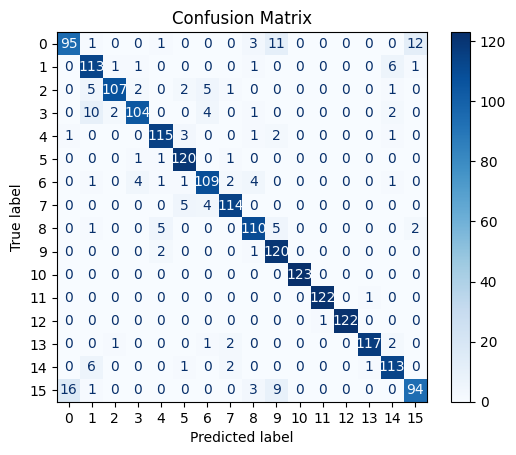

In [26]:
print_confusion_matrix()